# How to reproduce this analysis

## Install the environment

Environment yaml and lock file are distributed with the notebook

```
mamba env create -f /path/to/probe-anno_env_locked.yaml
or for development
mamba env create -f /path/to/probe-anno_env.yaml
```

## Create a project directory and copy the manifest file into it

- create a project directory
- copy the manifest file somewhere into this project directory
- specify these paths in the Config section

## Specify the available number of cores

The number of cores can be specified in the Config section as well

# Setup

## Config (ADAPT)

In [1]:
# TODO: set number of available cores as needed
n_cores = 12

In [2]:
# TODO: set basic paths as needed
project_dir = (
    "/omics/groups/OE0029/internal/kraemers/projects/epic-arrays-for-hematopoiesis"
)

# this file is distributed with the notebook, place it somewhere in project_dir
# and note the location here
illumina_probes_csv = (
    project_dir
    + "/Infinium_20Mouse_20Methylation_20v1.0_20A1_20GS_20Manifest_20File.csv"
)

## Imports

In [3]:
import os

num_threads = str(n_cores)

# these need to be set prior to numpy import
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

import numpy as np

import subprocess
import tempfile
from pathlib import Path
from typing import Dict

import gtfanno as ga
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pyranges as pr
from IPython.display import display

## Rerun flags

In [13]:
recompute = True

## Paths and URLs

In [14]:
# ### Input data urls and filepaths

#### Reference genomes

In [15]:
mm10_fa_url = 'http://hgdownload.cse.ucsc.edu/goldenpath/mm10/bigZips/mm10.fa.gz'
mm10_fa = project_dir + '/ucsc_mm10.fa.gz'
mm10_fa_bgz = project_dir + '/ucsc_mm10.fa.bgz'

In [16]:
ncbi_mm10_fa_url = 'https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_mammalian/Mus_musculus/all_assembly_versions/GCF_000001635.26_GRCm38.p6/GCF_000001635.26_GRCm38.p6_genomic.fna.gz'
ncbi_mm10_fa = project_dir + '/ncbi_mm10.fa.gz'
ncbi_mm10_fa_bgz = project_dir + '/ncbi_mm10.fa.bgz'

In [17]:
chrom_alias_url = 'https://hgdownload.cse.ucsc.edu/goldenPath/mm10/database/chromAlias.txt.gz'
chrom_alias_txt_gz = project_dir + '/chromAlias.txt.gz'

#### Gencode

In [18]:
gencode_download_url = "ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.annotation.gtf.gz"

# unmodified gencode gtf (note: with chr prefix)
gencode_gtf = project_dir + "/gencode.vM25.annotation.gtf.gz"

# gencode filtered for principal transcripts of protein coding genes, note that that chromosome prefix ('chr') is removed in this file
gencode_coding_canonical_gtf = (
    project_dir + "/gencode.vM25.annotation_coding_canonical.gtf.gz"
)

#### CpG islands

In [19]:
cpg_islands_ucsc_unmasked_url = 'http://hgdownload.cse.ucsc.edu/goldenpath/mm10/database/cpgIslandExtUnmasked.txt.gz'
cpg_islands_ucsc_unmasked_txt_gz = project_dir + "/cpg-islands_ucsc_unmasked.txt.gz"

#### Probes

originally retrieved from:
illumina_probes_url = "https://support.illumina.com/content/dam/illumina-support/documents/downloads/productfiles/mouse-methylation/Infinium%20Mouse%20Methylation%20v1.0%20A1%20GS%20Manifest%20File.csv"
saved to repo in case the link is not stable, use from here in the future (see Config section)

### Output file paths

#### gtfanno results

In [20]:
custom_intervals_results_dir = project_dir + "/custom-intervals_1500-500"
os.makedirs(custom_intervals_results_dir, exist_ok=True)

custom_intervals_trunk_path = (
    custom_intervals_results_dir + "/custom-intervals_1500-500"
)
custom_intervals_trunk_path

custom_intervals_results_paths_d = dict(
    primary_annos_bed=custom_intervals_trunk_path + "_primary-annotations.bed",
    primary_annos_p=custom_intervals_trunk_path + "_primary-annotations.p",
    all_annos_bed=custom_intervals_trunk_path + "_all-annotations.bed",
    all_annos_p=custom_intervals_trunk_path + "_all-annotations.p",
)

#### Final tables with CpG island and motif annotations

In [21]:
probe_annos_one_row_bed_csv = project_dir + "/gene-annos_primary_one-row_v2.bed"
probe_annos_one_row_bed_parquet = project_dir + "/gene-annos_primary_one-row_v2.parquet"

## TemporaryDirectory

In [22]:
temp_dir_obj = tempfile.TemporaryDirectory(dir=project_dir)
temp_dir_name = temp_dir_obj.name
temp_dir_name

'/omics/groups/OE0029/internal/kraemers/projects/epic-arrays-for-hematopoiesis/tmpjt59wker'

# Functions and objects
## Dtypes

In [23]:
chrom_dtype_prefixed = pd.api.types.CategoricalDtype(
    categories=[
        "chr1",
        "chr2",
        "chr3",
        "chr4",
        "chr5",
        "chr6",
        "chr7",
        "chr8",
        "chr9",
        "chr10",
        "chr11",
        "chr12",
        "chr13",
        "chr14",
        "chr15",
        "chr16",
        "chr17",
        "chr18",
        "chr19",
        "chrX",
        "chrY",
        "chrMT",
    ],
    ordered=True,
)

## Merge multiple gene annos per probe

In [24]:
def merge_annos(
    primary_annos: pd.DataFrame,
    #     chrom_dtype: pd.api.types.CategoricalDtype,
) -> pd.DataFrame:
    """Merge annotation format with multiple rows per DMR"""

    # TODO: could use some print statements

    # Merge information as CSV for fields with different values for different annotations
    fields_with_different_values = [
        "perc_feature",
        "perc_region",
        "distance",
        "has_center",
        "gene_name",
        "gene_id",
        "transcript_id",
        "appris_principal_score",
        "feat_start",
        "feat_end",
        "feat_center",
        "feat_strand",
    ]

    fields_with_unique_values = [
        f for f in primary_annos.columns if f not in fields_with_different_values
    ]

    # float fields require special str formatting
    float_fields = [
        f
        for f in fields_with_different_values
        if pd.api.types.is_float_dtype(primary_annos.dtypes[f])
    ]

    # When we concatenate, we need to convert all fields to str/object dtype
    primary_annos_new_dtypes = primary_annos.copy()
    primary_annos_new_dtypes[float_fields] = primary_annos_new_dtypes[
        float_fields
    ].round(2)
    primary_annos_new_dtypes[fields_with_different_values] = primary_annos_new_dtypes[
        fields_with_different_values
    ].astype(str)

    # computations are expensive, so only perform on features which are actually duplicated
    # always take gtfanno_uid into the mix so that we can avoid problems with duplicate regions
    # (which occur for example on the EPIC array)
    is_duplicated = primary_annos_new_dtypes.duplicated(
        subset=["Chromosome", "Start", "End", "gtfanno_uid"], keep=False
    )
    duplicated_df = primary_annos_new_dtypes.loc[is_duplicated].copy()

    #     primary_annos.query('feat_class == "Promoter"')

    print("merge unique value fields")
    merged_different_value_fields_df = (
        duplicated_df
        # for testing
        # .query('feat_class == "Promoter"')
        # .head(50)
        # / for testing
        .groupby(
            ["Chromosome", "Start", "End", "gtfanno_uid"], observed=True, as_index=False
        )[fields_with_different_values].aggregate(_agg_multi_value_columns)
    )
    merged_different_value_fields_df

    # Assert that unique value fields are really unique (1 or 0 unique values if nan)

    duplicated_df

    assert (
        duplicated_df
        # .head(100)
        .groupby(["Chromosome", "Start", "End", "gtfanno_uid"], observed=True)[
            fields_with_unique_values
        ]
        .agg(lambda ser: ser.nunique())
        # bug: nunique() does not respected observed atm
        # .nunique()
        .isin([0, 1])
        .all()
        .all()
    )

    merged_unique_value_fields_df = duplicated_df.groupby(
        ["Chromosome", "Start", "End", "gtfanno_uid"],
        observed=True,
        as_index=False,
    )[fields_with_unique_values].first()
    merged_unique_value_fields_df

    merged_duplicated_annos = pd.concat(
        [
            merged_different_value_fields_df.drop(
                ["Chromosome", "Start", "End", "gtfanno_uid"], axis=1
            ),
            merged_unique_value_fields_df,
        ],
        axis=1,
    )[primary_annos.columns]
    merged_duplicated_annos

    full_merged_annos = pd.concat(
        [primary_annos_new_dtypes.loc[~is_duplicated], merged_duplicated_annos], axis=0
    ).sort_values(["Chromosome", "Start", "End"])
    full_merged_annos

    assert (
        full_merged_annos["gtfanno_uid"] == np.arange(full_merged_annos.shape[0])
    ).all()

    return full_merged_annos.reset_index(drop=True)


def _agg_multi_value_columns(ser):
    if ser.eq("nan").all():
        return "nan"
    else:
        return ser.str.cat(sep=",")

## Classify cytosine motifs

In [25]:
def classify_motif(s):
    if s[2] == "C":
        if s[3] == "G":
            return "CG"
        elif s[3] == "N":
            return "CN"
        elif s[4] == "G":
            return "CHG"
        elif s[4] == "N":
            return "CHN"
        else:
            return "CHH"
    elif s[2] == "G":
        if s[1] == "C":
            return "CG"
        elif s[1] == "N":
            return "CN"
        elif s[0] == "C":
            return "CHG"
        elif s[0] == "N":
            return "CHN"
        else:
            return "CHH"
    else:
        return "D"

In [26]:
def find_cytosine_strand_and_motif(df, temp_dir_name, fa_bgz):
    """

    chrom names must match ref genome
    """

    regions_txt = temp_dir_name + "/regions.txt"
    Path(regions_txt).write_text(
        (
            df["Chromosome"].astype(str)
            + ":"
            + df["Start"].add(1 - 2).astype(str)
            + "-"
            + df["End"].add(2).astype(str)
        ).str.cat(sep="\n")
    )


    res_txt = temp_dir_name + "/res.txt"
    proc2 = subprocess.run(
        [
            "samtools",
            "faidx",
            "-r",
            regions_txt,
            "-o",
            res_txt,
            fa_bgz,
        ],
        check=True,
        capture_output=True,
        encoding="utf-8",
    )

    bases_ser = pd.Series(
        [s for s in Path(res_txt).read_text().upper().split() if not s.startswith(">")]
    )

    strand_ser = bases_ser.str.slice(2, 3).map({"C": "+", "G": "-"}).fillna("NA")
    motifs_ser = bases_ser.map(classify_motif)

    return strand_ser, motifs_ser

# Analysis

## Prepare and inspect the probe manifest

In [27]:
!head {illumina_probes_csv}

Illumina, Inc.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[Heading],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Descriptor File Name,MouseMethylation-12v1-0_A1.csv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Assay Format,Infinium 2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Date Manufactured,10/15/2020,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Loci Count,287050,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[Assay],,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,Top_Sequence,Genome_Build,Genome_Build_NCBI,CHR,MAPINFO,SourceSeq,Strand,Strand_TB,Strand_CO,N_Shelf,N_Shore,CpG_Island,CpG_Island_chrom,CpG_Island_chromStart,CpG_Island_chromEnd,CpG_Island_length,CpG_Island_cpgNum,CpG_Island_gcNum,CpG_Island_perCpg,CpG_Island_perGc,CpG_Island_obsExp,S_Shore,S_Shelf,MFG_Change_Flagged
cg00101675_BC21,cg00101675,91684905,TTCCTAAAAAAACTTCAACAATACTATATCATTTTTAACTTCATAAACAC,,,II,,,AGCCTGAACTGTTCCTAAAGAAACTTCAGCAGTGCTGTGTCATTTTTGACTTCATGGACA[CG]CTATCTGA

### Get curated BED intervals for probes

In [28]:
illumina_probes = pd.read_csv(
    illumina_probes_csv,
    skiprows=7,
    dtype={
        "AddressA_ID": str,
        "CHR": str,
        "MFG_Change_Flagged": "boolean",
        "MAPINFO": "Int64",
    },
)

exemplary row, drop fields with longish sequence strings for display

In [29]:
illumina_probes.drop(["Forward_Sequence", "Top_Sequence"], axis=1).iloc[0].to_frame()

,0
IlmnID,cg00101675_BC21
Name,cg00101675
AddressA_ID,91684905
AlleleA_ProbeSeq,TTCCTAAAAAAACTTCAACAATACTATATCATTTTTAACTTCATAA...
AddressB_ID,NaN
AlleleB_ProbeSeq,NaN
Infinium_Design_Type,II
Next_Base,NaN
Color_Channel,NaN
Genome_Build,mm10


There are CHR in ['0', nan] probes

In [30]:
illumina_probes.CHR.value_counts(dropna=False)

2      21675
11     18941
7      18875
4      18151
5      17173
1      17077
X      15147
9      14907
10     14824
6      14427
8      13998
3      13511
17     13055
13     11861
15     11458
12     11130
14     10532
16      9093
18      8596
19      8508
Y       3665
NaN      643
0        410
MT        36
Name: CHR, dtype: int64

example for control probe (everything NA)

In [31]:
illumina_probes.loc[illumina_probes.CHR.isnull()].drop(
    ["Forward_Sequence", "Top_Sequence"], axis=1
).iloc[0].to_frame()

,287050
IlmnID,[Controls]
Name,NaN
AddressA_ID,NaN
AlleleA_ProbeSeq,NaN
AddressB_ID,NaN
AlleleB_ProbeSeq,NaN
Infinium_Design_Type,NaN
Next_Base,NaN
Color_Channel,NaN
Genome_Build,NaN


example for chromosome 0 probe

In [32]:
illumina_probes.loc[illumina_probes.CHR.eq("0")].drop(
    ["Forward_Sequence", "Top_Sequence"], axis=1
).iloc[0].to_frame()

,285698
IlmnID,rs108256820_TC11
Name,rs108256820
AddressA_ID,56784359
AlleleA_ProbeSeq,ACTCCTATTTCACTAACTAAAAAAACTTATCCCAAAAAAACACAAA...
AddressB_ID,91708393.0
AlleleB_ProbeSeq,ACTCCTATTTCACTAACTAAAAAAACTTATCCCAAAAAAACACAAA...
Infinium_Design_Type,I
Next_Base,G
Color_Channel,Grn
Genome_Build,mm10


checked manually in my index files: MAPINFO is 1-based Start info

- add 'chr' prefix and make Categorical
- provide BED interval for the 1-bp long cytosine intervals
- restrict to columns Chromosome, Start, End

In [33]:
illumina_probe_intervals_bed_convention = (
    illumina_probes[["CHR", "MAPINFO", "IlmnID"]]
    .rename(columns={"CHR": "Chromosome", "MAPINFO": "Start", "IlmnID": "name"})
    .assign(
        Start=lambda df: df["Start"] - 1,
        End=lambda df: df["Start"] + 1,
        Chromosome=lambda df: ("chr" + df["Chromosome"]).astype(chrom_dtype_prefixed),
    )[["Chromosome", "Start", "End", "name"]]
)


illumina_probes_curated_chrom_defined = (
    illumina_probe_intervals_bed_convention.loc[
        lambda df: df.Chromosome.notnull() & df.Chromosome.ne("0")
    ]
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
)

assert that we have only lost the chromosome 0|na probes

In [34]:
n_probes_chr_defined = (
    illumina_probes.shape[0] - illumina_probes.CHR.isin(["0", np.nan]).sum()
)
assert n_probes_chr_defined == illumina_probes_curated_chrom_defined.shape[0]

There are duplicated intervals, ie same interval, different probes, with different names

In [35]:
illumina_probes_curated_chrom_defined[["Chromosome", "Start", "End"]].duplicated().sum()

4634

to get unique intervals for annotation with gtfanno
- drop duplicate rows
- remove prefix
- change to alphabetic sorting order
- only save the grange columns

In [36]:
illumina_coordinate_bed = temp_dir_name + '/illumina-coordinates.bed'

In [37]:
illumina_probes_curated_chrom_defined.assign(
    Chromosome=lambda df: df.Chromosome.astype(str).str.replace("chr", "")
).iloc[:, 0:3].sort_values(["Chromosome", "Start", "End"]).drop_duplicates().to_csv(
    illumina_coordinate_bed, sep="\t", header=False, index=False
)

In [38]:
!head {illumina_coordinate_bed}

1	3005997	3005998
1	3006186	3006187
1	3035832	3035833
1	3062738	3062739
1	3102469	3102470
1	3121638	3121639
1	3199333	3199334
1	3216334	3216335
1	3253526	3253527
1	3275903	3275904


In [39]:
illumina_probes_curated_chrom_defined_no_names_no_dup_intervals = (
    illumina_probes_curated_chrom_defined[
        ["Chromosome", "Start", "End"]
    ].drop_duplicates(subset=["Chromosome", "Start", "End"])
).reset_index(drop=True)

## Gene annotation

### Prepare gene annotation

#### download gencode

In [ ]:
if recompute:
    subprocess.run(
        ["wget", "-O", gencode_gtf, gencode_download_url],
        check=True,
        capture_output=True,
    )

#### Filter and reformat gencode GTF

- restrict to canonical transcripts
- restrict to coding transcripts
- remove chr prefix
- change M to MT

In [40]:
gencode_df = pr.read_gtf(gencode_gtf, as_df=True, duplicate_attr=True)

In [41]:
# extract appris principal score from tags
appris_principal_score = (
    gencode_df["tag"].str.extract(r"appris_principal_(\d)", expand=False).astype(float)
)

In [42]:
appris_principal_score.value_counts()

1.0    484929
2.0     88170
3.0     69849
4.0     15559
5.0      8279
Name: tag, dtype: int64

In [43]:
appris_principal_score.isnull().sum()

1205266

In [44]:
appris_principal_score.notnull().sum()

666786

In [45]:
is_principal_transcript = appris_principal_score.notnull()

In [46]:
is_protein_coding = gencode_df["gene_type"].eq("protein_coding")

In [47]:
gencode_df_coding_canonical = gencode_df.loc[
    is_principal_transcript & is_protein_coding
].copy()

In [48]:
gencode_df_coding_canonical.head(3)

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont
13,chr1,HAVANA,transcript,3214481,3671498,.,-,.,ENSMUSG00000051951.5,protein_coding,...,protein_coding,Xkr4-201,1,"basic,appris_principal_1,CCDS",OTTMUST00000065166.1,NaN,NaN,ENSMUSP00000070648.4,CCDS14803.1,NaN
14,chr1,HAVANA,exon,3670551,3671498,.,-,.,ENSMUSG00000051951.5,protein_coding,...,protein_coding,Xkr4-201,1,"basic,appris_principal_1,CCDS",OTTMUST00000065166.1,1,ENSMUSE00000485541.3,ENSMUSP00000070648.4,CCDS14803.1,NaN
15,chr1,HAVANA,CDS,3670551,3671348,.,-,0,ENSMUSG00000051951.5,protein_coding,...,protein_coding,Xkr4-201,1,"basic,appris_principal_1,CCDS",OTTMUST00000065166.1,1,ENSMUSE00000485541.3,ENSMUSP00000070648.4,CCDS14803.1,NaN


In [49]:
gencode_df_coding_canonical.shape

(663082, 25)

In [50]:
gencode_df_coding_canonical["Chromosome"] = gencode_df_coding_canonical[
    "Chromosome"
].str.replace("chr", "")
gencode_df_coding_canonical["Chromosome"] = gencode_df_coding_canonical[
    "Chromosome"
].replace("M", "MT")

In [51]:
gencode_pr = pr.PyRanges(gencode_df_coding_canonical)
gencode_pr.df.Chromosome.unique()

['1', '2', '3', '4', '5', ..., '18', '19', 'MT', 'X', 'Y']
Length: 22
Categories (22, object): ['1', '10', '11', '12', ..., '9', 'MT', 'X', 'Y']

In [52]:
gencode_pr.to_gtf(gencode_coding_canonical_gtf)

verify gtf

In [54]:
!zcat {gencode_coding_canonical_gtf} | grep ^protein_coding

In [55]:
!zcat {gencode_coding_canonical_gtf} | grep ^appris

### Perform gene annotations

In [ ]:
if recompute:
    ga.annotate(
        query_bed=illumina_coordinate_bed,
        gtf_fp=gencode_coding_canonical_gtf,
        trunk_path=custom_intervals_trunk_path,
        tmpdir=temp_dir_name,
        promoter=(-1500, 500),
        distant_cis_regulatory_domain=(-100_000, 100_000),
    )

In [56]:
primary_annos = pd.read_pickle(
    custom_intervals_results_paths_d["primary_annos_p"]
)

#### Multiple assignments per region

##### How is this distributed across feature classes?

In [57]:
multi_annos_crosstab = (
    primary_annos.groupby(["feat_class", "gtfanno_uid"], observed=True)
    .size()
    .groupby("feat_class")
    .value_counts()
    .unstack()
)
multi_annos_crosstab

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
feat_class,,,,,,,,,,,,,,,,,,,,,
Promoter,56553.0,4704.0,184.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5'-UTR,1003.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3'-UTR,5284.0,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
exon,26634.0,186.0,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
intron,90028.0,1929.0,84.0,4.0,10.0,6.0,5.0,1.0,3.0,9.0,...,9.0,NaN,1.0,NaN,5.0,9.0,4.0,NaN,8.0,NaN
DCRD,21944.0,13133.0,8339.0,5246.0,3632.0,2371.0,1574.0,1200.0,909.0,635.0,...,51.0,93.0,54.0,22.0,12.0,15.0,7.0,3.0,1.0,7.0
intergenic,34506.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Example for Promoter multiple annotations

In [58]:
primary_annos["is_duplicated"] = primary_annos.duplicated(
    subset=["Chromosome", "Start", "End"], keep=False
)

In [59]:
df = primary_annos.query('feat_class == "Promoter" & is_duplicated')[
    ["Chromosome", "Start", "End", "gtfanno_uid", "gene_name"]
]
display(df.head(20))
display(df.tail(20))

,Chromosome,Start,End,gtfanno_uid,gene_name
238,1,4808196,4808197,96,Gm37988
239,1,4808196,4808197,96,Lypla1
244,1,4808291,4808292,97,Gm37988
245,1,4808291,4808292,97,Lypla1
1252,1,10037877,10037878,355,Cspp1
1253,1,10037877,10037878,355,Cops5
1259,1,10038004,10038005,356,Cspp1
1260,1,10038004,10038005,356,Cops5
1266,1,10038459,10038460,357,Cops5
1267,1,10038459,10038460,357,Cspp1


,Chromosome,Start,End,gtfanno_uid,gene_name
1638159,X,155624572,155624573,277148,Ptchd1
1638160,X,155624572,155624573,277148,Gm15155
1638161,X,155624668,155624669,277149,Ptchd1
1638162,X,155624668,155624669,277149,Gm15155
1641301,X,164980364,164980365,278241,Fancb
1641302,X,164980364,164980365,278241,Mospd2
1641304,X,164980482,164980483,278242,Mospd2
1641305,X,164980482,164980483,278242,Fancb
1641307,X,164980683,164980684,278243,Mospd2
1641308,X,164980683,164980684,278243,Fancb


Nsdhl
http://nov2020.archive.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000031349;r=X:71962163-72002120

Rpl7
http://nov2020.archive.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000043716;r=1:16171519-16174886

### Merge gene annotations (one row per unique probe interval)

Merging strategy: keep all
- for Promoters, the window is relatively small. Ranking on TSS distance in such a small window seems arbitrary.
- for enhancer candidates, a typical strategy would be to identify all TSS in +-100 kb window and try to find the target through correlation with gene expression, eg PMID: 30686579. So it also makes sense to indicate all genes in the window to give an impression of the number of possible target genes.

In [60]:
merged_annos = merge_annos(primary_annos=primary_annos)
merged_annos

merge unique value fields


,Chromosome,Start,End,gtfanno_uid,center,feat_class,perc_feature,perc_region,distance,has_center,...,gene_id,transcript_id,appris_principal_score,feat_chrom,feat_start,feat_end,feat_center,feat_strand,feature_rank,is_duplicated
0,1,3005997,3005998,0,NaN,intergenic,nan,nan,nan,nan,...,nan,nan,nan,NaN,nan,nan,nan,nan,primary,False
1,1,3006186,3006187,1,NaN,intergenic,nan,nan,nan,nan,...,nan,nan,nan,NaN,nan,nan,nan,nan,primary,False
2,1,3035832,3035833,2,NaN,intergenic,nan,nan,nan,nan,...,nan,nan,nan,NaN,nan,nan,nan,nan,primary,False
3,1,3062738,3062739,3,NaN,intergenic,nan,nan,nan,nan,...,nan,nan,nan,NaN,nan,nan,nan,nan,primary,False
4,1,3102469,3102470,4,NaN,intergenic,nan,nan,nan,nan,...,nan,nan,nan,NaN,nan,nan,nan,nan,primary,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282001,Y,90808022,90808023,282001,90808022.5,DCRD,nan,nan,31154.5,True,...,ENSMUSG00000096850.1,ENSMUST00000179623.1,0.0,Y,90739177.0,90939177.0,nan,-,primary,False
282002,Y,90808868,90808869,282002,90808868.5,DCRD,nan,nan,30308.5,True,...,ENSMUSG00000096850.1,ENSMUST00000179623.1,0.0,Y,90739177.0,90939177.0,nan,-,primary,False
282003,Y,90809535,90809536,282003,90809535.5,DCRD,nan,nan,29641.5,True,...,ENSMUSG00000096850.1,ENSMUST00000179623.1,0.0,Y,90739177.0,90939177.0,nan,-,primary,False
282004,Y,90813404,90813405,282004,90813404.5,DCRD,nan,nan,25772.5,True,...,ENSMUSG00000096850.1,ENSMUST00000179623.1,0.0,Y,90739177.0,90939177.0,nan,-,primary,False


In [61]:
merged_annos_new_chrom_dtype = merged_annos.copy()
merged_annos_new_chrom_dtype["Chromosome"] = (
    "chr" + merged_annos["Chromosome"].astype(str)
).astype(chrom_dtype_prefixed)
merged_annos_new_chrom_dtype = (
    merged_annos_new_chrom_dtype.sort_values(["Chromosome", "Start", "End"])
    .drop("gtfanno_uid", axis=1)
    .reset_index(drop=True)
)
assert merged_annos_new_chrom_dtype["Chromosome"].notnull().all()

In [62]:
merged_annos_new_chrom_dtype = merged_annos_new_chrom_dtype.astype(
    {"Start": "Int64", "End": "Int64"}
)

## CpG island annotations

### Download CpG island regions from UCSC

In [63]:
if recompute:
    subprocess.run(
        [
            "wget",
            "-O",
            cpg_islands_ucsc_unmasked_txt_gz,
            cpg_islands_ucsc_unmasked_url,
        ],
        check=True,
        capture_output=True,
    )

### Read in CpG islands

In [64]:
cpg_islands_df_prelim = pd.read_csv(  # type: ignore
        cpg_islands_ucsc_unmasked_txt_gz,
        sep="\t",
        header=None,
        names="bin Chromosome Start End name length cpgNum gcNum perCpg perGc obsExp".split(),
    )

no MT cpg islands

In [65]:
print(
    "chrMT" in cpg_islands_df_prelim.Chromosome.unique(),
    "chrM" in cpg_islands_df_prelim.Chromosome.unique(),
)

False False


In [66]:
cpg_islands_df = (cpg_islands_df_prelim
    .astype({"Chromosome": chrom_dtype_prefixed})
    .dropna()
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
)

### Compute shores and shelves

In [67]:
cpg_upstream_shores = cpg_islands_df[["Chromosome", "Start", "End"]].copy()
cpg_upstream_shores["End"] = cpg_islands_df["Start"]
cpg_upstream_shores["Start"] = cpg_islands_df["Start"] - 2000
cpg_downstream_shores = cpg_islands_df[["Chromosome", "Start", "End"]].copy()
cpg_downstream_shores["Start"] = cpg_islands_df["End"]
cpg_downstream_shores["End"] = cpg_islands_df["End"] + 2000
cpg_shores_df = (
    pd.concat([cpg_upstream_shores, cpg_downstream_shores], axis=0)
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
    .astype({"Chromosome": chrom_dtype_prefixed})
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
)

In [68]:
cpg_upstream_shelves = cpg_islands_df[["Chromosome", "Start", "End"]].copy()
cpg_upstream_shelves["End"] = cpg_islands_df["Start"] - 2000
cpg_upstream_shelves["Start"] = cpg_islands_df["Start"] - 4000
cpg_downstream_shelves = cpg_islands_df[["Chromosome", "Start", "End"]].copy()
cpg_downstream_shelves["Start"] = cpg_islands_df["End"] + 2000
cpg_downstream_shelves["End"] = cpg_islands_df["End"] + 4000
cpg_shelves_df = (
    pd.concat([cpg_upstream_shelves, cpg_downstream_shelves], axis=0)
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
    .astype({"Chromosome": chrom_dtype_prefixed})
    .sort_values(["Chromosome", "Start", "End"])
    .reset_index(drop=True)
)

In [69]:
cpg_islands_regions_gr_d = {'cpg_island': pr.PyRanges(cpg_islands_df[['Chromosome', 'Start', 'End']]),
                    'cpg_shore': pr.PyRanges(cpg_shores_df),
                    'cpg_shelve': pr.PyRanges(cpg_shelves_df),
                    }

### Join probe and cpg region intervals

In [70]:
illumina_probes_curated_chrom_defined_no_names_do_dup_intervals_gr = pr.PyRanges(
    illumina_probes_curated_chrom_defined_no_names_no_dup_intervals
)

In [71]:
# join against cpg islands, shelves, shores
dfs = []
for cpg_island_region_name, cpg_island_region_gr in cpg_islands_regions_gr_d.items():
    join_gr = illumina_probes_curated_chrom_defined_no_names_do_dup_intervals_gr.join(
        cpg_island_region_gr,
        how=None,
    )
    join_df = join_gr.df.rename(
        columns={"Start_b": "region_start", "End_b": "region_end"}
    )[
        [
            "Chromosome",
            "Start",
            "End",
            "region_start",
            "region_end",
        ]
    ].assign(region_name=cpg_island_region_name)
    dfs.append(join_df)
# NOTE: pyranges may change sorting order
cpg_island_anno_df = pd.concat(dfs, axis=0).reset_index(drop=True)

### Inspect multi-class assignments

some cpgs are part of multiple features, e.g. cpg is located in a CpG island and in the shelve region of another CpG island; or a CpG is located in two shelve regions of different CpG islands

In [72]:
cpg_island_grange_cols = ["Chromosome", "Start", "End"]
cpg_island_anno_df.groupby(cpg_island_grange_cols, observed=True).size().value_counts()

1    67471
2     9812
3     1812
4      285
5       39
6        5
dtype: int64

In [73]:
cpg_island_anno_df.set_index(cpg_island_grange_cols).loc[
    cpg_island_anno_df.groupby(cpg_island_grange_cols, observed=True).size().gt(2)
].sort_values(cpg_island_grange_cols)

region_start  region_end region_name
Chromosome Start     End                                            
chr1       12992476  12992477       12991485    12992784  cpg_island
                     12992477       12991200    12993200   cpg_shore
                     12992477       12992222    12994222  cpg_shelve
           12992878  12992879       12991200    12993200   cpg_shore
                     12992879       12992784    12994784   cpg_shore
...                                      ...         ...         ...
chrX       170677384 170677385     170675836   170677836  cpg_shelve
                     170677385     170677049   170679049  cpg_shelve
chrY       90762037  90762038       90761349    90762300  cpg_island
                     90762038       90761086    90763086   cpg_shore
                     90762038       90760383    90762383  cpg_shelve

[6801 rows x 3 columns]

Sanity check: no CpG is annotated to two CpG islands

In [74]:
cpg_island_anno_df.query('region_name == "cpg_island"').groupby(
    cpg_island_grange_cols, observed=True
).size().value_counts()

1    31545
dtype: int64

### pick unique classif according to precedence

In [76]:
cpg_island_anno_df_unique = (
    cpg_island_anno_df.assign(
        region_name=lambda df: pd.Categorical(
            df["region_name"],
            categories=["cpg_island", "cpg_shelve", "cpg_shore", "open_sea"],
        )
    )
    .sort_values(["Chromosome", "Start", "End", "region_name"], ascending=True)
    .groupby(cpg_island_grange_cols, observed=True, as_index=False)
    .first()
    .assign(
        Chromosome=lambda df: df["Chromosome"].astype(
            illumina_probes_curated_chrom_defined.Chromosome.dtype
        )
    )
)

### add open sea probes

the grange join operation has discarded open sea cpgs, merge to get them back

In [79]:
full_cpg_island_anno_df = pd.merge(
    illumina_probes_curated_chrom_defined_no_names_no_dup_intervals,
    cpg_island_anno_df_unique,
    on=cpg_island_grange_cols,
    how="left",
)

In [80]:
# assert: the open sea cpgs have no region_name yet, all other features do have a region_name
assert (
    full_cpg_island_anno_df.region_name.notnull().sum()
    == cpg_island_anno_df_unique.shape[0]
)

In [81]:
full_cpg_island_anno_df["region_name"] = full_cpg_island_anno_df["region_name"].fillna(
    "open_sea"
)

### add distance to nearest CpG island

In [82]:
nearest_cpg_island_grange = illumina_probes_curated_chrom_defined_no_names_do_dup_intervals_gr.nearest(
    cpg_islands_regions_gr_d['cpg_island'],
    strandedness=False,
    overlap=True,
    how=None,
)

In [83]:
# Distance computed by pyranges has no sign, add it
nearest_cpg_island_df = nearest_cpg_island_grange.df.copy()
is_upstream = nearest_cpg_island_df.eval("Start < Start_b")
is_downstream = nearest_cpg_island_df.eval("Start >= End_b")
nearest_cpg_island_df["distance_signed"] = 0
nearest_cpg_island_df.loc[is_upstream, "distance_signed"] = nearest_cpg_island_df.loc[
    is_upstream
].eval("(End - 1) - Start_b")
nearest_cpg_island_df.loc[is_downstream, "distance_signed"] = nearest_cpg_island_df.loc[
    is_downstream
].eval("Start - (End_b - 1)")

pd.testing.assert_series_equal(
    nearest_cpg_island_df.distance_signed.abs(),
    nearest_cpg_island_df.Distance,
    check_names=False,
)

### add coords of nearest CpG island to each probe

In [85]:
nearest_cpg_island_df = nearest_cpg_island_df.rename(
    columns={"Start_b": "next_cpg_island_start", "End_b": "next_cpg_island_end"}
)

full_cpg_island_anno_df_with_dist = pd.merge(
    full_cpg_island_anno_df,
    nearest_cpg_island_df[
        cpg_island_grange_cols
        + ["distance_signed", "next_cpg_island_start", "next_cpg_island_end"]
    ],
    on=cpg_island_grange_cols,
    how="left",
)
# fix lost chrom dtype (pandas problem)
full_cpg_island_anno_df_with_dist.Chromosome = (
    full_cpg_island_anno_df_with_dist.Chromosome.astype(
        illumina_probes_curated_chrom_defined.Chromosome.dtype
    )
)

In [86]:
pd.testing.assert_frame_equal(
    full_cpg_island_anno_df_with_dist.query('region_name == "CpG islands"')[
        ["region_start", "region_end"]
    ].set_axis(["a", "b"], axis=1),
    full_cpg_island_anno_df_with_dist.query('region_name == "CpG islands"')[
        ["next_cpg_island_start", "next_cpg_island_end"]
    ].set_axis(["a", "b"], axis=1),
)

In [87]:
full_cpg_island_anno_df_with_dist = full_cpg_island_anno_df_with_dist.drop(
    ["region_start", "region_end"], axis=1
).rename(
    columns={
        "next_cpg_island_start": "region_start",
        "next_cpg_island_end": "region_end",
    }
)

In [88]:
# quick sanity check on distance
assert (
    full_cpg_island_anno_df_with_dist.query('region_name == "cpg_island"')[
        "distance_signed"
    ]
    .eq(0)
    .all()
)

### Illumina style north/south annos

In [89]:
full_cpg_island_anno_df_with_dist["north_south_of_island"] = np.sign(
    full_cpg_island_anno_df_with_dist["distance_signed"]
).replace({0: "", 1: "N", -1: "S"})

full_cpg_island_anno_df_with_dist.loc[
    ~full_cpg_island_anno_df_with_dist.region_name.isin(["cpg_shore", "cpg_shelve"]),
    "north_south_of_island",
] = ""

### Final CpG island annos

In [90]:
full_cpg_island_anno_df_with_dist = full_cpg_island_anno_df_with_dist.rename(
    columns={
        "region_name": "cpg_island_region_name",
        "region_start": "cpg_island_region_start",
        "region_end": "cpg_island_region_end",
        "distance_signed": "cpg_island_distance",
        "north_south_of_island": "north_south_of_cpg_island",
    }
)

### Inspect CpG anno results

In [91]:
full_cpg_island_anno_df_with_dist['cpg_island_region_name'].value_counts()

open_sea      202582
cpg_island     31545
cpg_shore      31247
cpg_shelve     16632
Name: cpg_island_region_name, dtype: int64

In [92]:
# check that cpg islands and open sea have no north / south, but shelves and shores do have it
# check that strands are approx 50/50
pd.crosstab(
    full_cpg_island_anno_df_with_dist["cpg_island_region_name"],
    full_cpg_island_anno_df_with_dist["north_south_of_cpg_island"],
)

north_south_of_cpg_island,,N,S
cpg_island_region_name,,,
cpg_island,31545,0,0
cpg_shelve,0,8370,8262
cpg_shore,0,15704,15543
open_sea,202582,0,0


In [94]:
pd.testing.assert_frame_equal(
    full_cpg_island_anno_df_with_dist[cpg_island_grange_cols],
    illumina_probes_curated_chrom_defined_no_names_no_dup_intervals,
)

<AxesSubplot:ylabel='Frequency'>

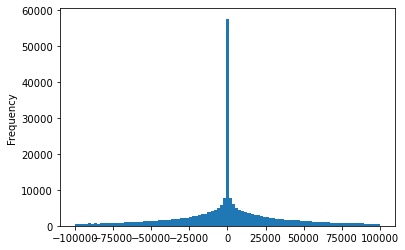

In [95]:
full_cpg_island_anno_df_with_dist["cpg_island_distance"].plot.hist(
    bins=np.linspace(-1e5, 1e5, 100)
)

## Add probe cytosine motif and strand

### Download ref genomes

ucsc mm10

In [ ]:
if recompute:
    subprocess.run(["wget", "-O", mm10_fa, mm10_fa_url], check=True)
    subprocess.run(
        f"zcat {mm10_fa} | bgzip > {mm10_fa_bgz}", shell=True, check=True
    )
    subprocess.run(["samtools", "faidx", mm10_fa_bgz], check=True)

NCBI GRCm38

In [ ]:
if recompute:
    subprocess.run(
        ["wget", "-O", ncbi_mm10_fa, ncbi_mm10_fa_url], check=True,
        capture_output=True,
    )
    subprocess.run(
        f"zcat {ncbi_mm10_fa} | bgzip > {ncbi_mm10_fa_bgz}",
        shell=True,
        check=True,
        capture_output=True,
    )
    subprocess.run(["samtools", "faidx", ncbi_mm10_fa_bgz], check=True, capture_output=True)

### download seq id mapper

In [ ]:
if recompute:
    subprocess.run(
        [
            "wget",
            "-O",
            chrom_alias_txt_gz,
            chrom_alias_url,
        ],
        check=True,
        capture_output=True,
    )

In [96]:
chrom_aliases = pd.read_csv(  # type_ignore
    chrom_alias_txt_gz,
    sep="\t",
    header=None,
    names=["other_db_id", "ucsc_id", "db"],
)

ucsc_to_refseq_chrom_name = chrom_aliases.query('db == "refseq"').set_index(
    "ucsc_id"
)["other_db_id"]

### Get strands and motifs

- a small number of probes does not cover cytosines
- comparing against two separately downloaded ref genomes just to be overly cautious about getting this right

In [97]:
ucsc_strand_ser, ucsc_motifs_ser = find_cytosine_strand_and_motif(
    temp_dir_name=temp_dir_name,
    df=illumina_probes_curated_chrom_defined_no_names_no_dup_intervals.assign(
        Chromosome=lambda df: df["Chromosome"].astype(str).replace({"chrMT": "chrM"})
    ),
    fa_bgz=mm10_fa_bgz,
)

In [98]:
df = illumina_probes_curated_chrom_defined_no_names_no_dup_intervals.assign(
    Chromosome=lambda df: df["Chromosome"]
    .astype(str)
    .replace({"chrMT": "chrM"})
    .map(ucsc_to_refseq_chrom_name)
)
assert df.Chromosome.notnull().all()

ncbi_strand_ser, ncbi_motifs_ser = find_cytosine_strand_and_motif(
    df=df,
    temp_dir_name=temp_dir_name,
    fa_bgz=ncbi_mm10_fa_bgz,
)

In [99]:
pd.testing.assert_series_equal(ncbi_strand_ser, ucsc_strand_ser)
pd.testing.assert_series_equal(ncbi_motifs_ser, ucsc_motifs_ser)

In [100]:
ncbi_motifs_ser.value_counts(dropna=False)
ncbi_strand_ser.value_counts(dropna=False)
ncbi_motifs_ser.loc[ncbi_strand_ser.eq("-")].value_counts()

CHH    85
CHG    11
dtype: int64

In [101]:
motifs_df_final = (
    illumina_probes_curated_chrom_defined_no_names_no_dup_intervals.reset_index(
        drop=True
    ).assign(strand=ncbi_motifs_ser, motif=ncbi_motifs_ser)
)

In [102]:
motifs_df_final["motif"].value_counts(dropna=False)

CG     280754
CHH       595
CHG       474
D         183
Name: motif, dtype: int64

## Merge all annotations

In [103]:
pd.testing.assert_frame_equal(
    full_cpg_island_anno_df_with_dist[["Chromosome", "Start", "End"]],
    illumina_probes_curated_chrom_defined_no_names_no_dup_intervals.reset_index(
        drop=True
    ),
)
pd.testing.assert_frame_equal(
    merged_annos_new_chrom_dtype[["Chromosome", "Start", "End"]],
    illumina_probes_curated_chrom_defined_no_names_no_dup_intervals.reset_index(
        drop=True
    ),
)

In [104]:
exp_number_of_nas = (
    illumina_probe_intervals_bed_convention["Chromosome"].isin([np.nan, "0"]).sum()
)

In [105]:
m1 = pd.merge(
    illumina_probe_intervals_bed_convention,
    motifs_df_final,
    on=["Chromosome", "Start", "End"],
    how="left",
)
assert m1["motif"].isnull().sum() == exp_number_of_nas

In [106]:
m2 = pd.merge(
    m1,
    full_cpg_island_anno_df_with_dist,
    on=["Chromosome", "Start", "End"],
    how="left",
)
assert m2["cpg_island_region_name"].isnull().sum() == exp_number_of_nas

In [107]:
m3 = pd.merge(
    m2,
    merged_annos_new_chrom_dtype,
    on=["Chromosome", "Start", "End"],
    how="left",
)
assert m3["feat_class"].isnull().sum() == exp_number_of_nas
m3["score"] = "."

In [108]:
final_cols_d = {
    "Chromosome": "Chromosome",
    "Start": "Start",
    "End": "End",
    "name": "IlmnID",
    "score": "Score",
    "strand": "Strand",
    "motif": "Motif",
    "feat_class": "Genomic_region_class",
    "distance": "Distance_to_genomic_region",
    "gene_name": "Gene_name",
    "gene_id": "Gene_id",
    "transcript_id": "Transcript_id",
    "feat_strand": "Gene_strand",
    "cpg_island_region_name": "Cpg_island_region_class",
    "cpg_island_region_start": "Cpg_island_region_start",
    "cpg_island_region_end": "Cpg_island_region_end",
    "cpg_island_distance": "Cpg_island_distance",
}

final_anno_table = m3[list(final_cols_d.keys())].rename(columns=final_cols_d)

assert (
    final_anno_table.query('Cpg_island_region_class == "CpG islands"')[
        "Cpg_island_distance"
    ]
    .eq(0)
    .all()
)

final_anno_table.query("Cpg_island_distance != 0")[
    ["Start", "Cpg_island_region_start", "Cpg_island_region_end", "Cpg_island_distance"]
]

,Start,Cpg_island_region_start,Cpg_island_region_end,Cpg_island_distance
0,75515718,75595357.0,75596718.0,-79639.0
1,12170849,12204780.0,12205688.0,-33931.0
2,57387383,57392570.0,57393038.0,-5187.0
3,6375936,6375517.0,6375855.0,82.0
4,35572741,35562004.0,35563062.0,9680.0
...,...,...,...,...
287688,<NA>,NaN,NaN,NaN
287689,<NA>,NaN,NaN,NaN
287690,<NA>,NaN,NaN,NaN
287691,<NA>,NaN,NaN,NaN


In [109]:
final_anno_table.rename(columns={"Chromosome": "#Chromosome"}).to_csv(
    probe_annos_one_row_bed_csv, sep="\t", header=True, index=False
)
final_anno_table.to_parquet(probe_annos_one_row_bed_parquet)